# MODEL - IMAGE LOADING & NEURAL NETWORK

In [1]:
#Import libraries
import gc
import csv
import os
import io
import cv2
from PIL import Image
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras_cv
import random
from collections.abc import Generator

TF_ENABLE_ONEDNN_OPTS=0

c:\Users\Andrew\anaconda3\envs\cancer_isic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) HYPERPARAMETERS

In [2]:
#Hyperparameters
train_frac_to_use = 0.05   #Reduce training data to this fraction
val_frac_to_use = 0.05     #Reduce validation data to this fraction
test_frac_to_use = 0.05     #Reduce validation data to this fraction
save_val_in_memory = False

## 2) GENERAL FUNCTIONS

In [3]:
"""
#Function to show image
def show_img(image):
    plt.imshow(image, interpolation=None)
    plt.grid(None)
    plt.show()
"""

'\n#Function to show image\ndef show_img(image):\n    plt.imshow(image, interpolation=None)\n    plt.grid(None)\n    plt.show()\n'

In [4]:
#Image cropping
def crop_image(images_list, nbPix = 100):
    output_images = []
    for image in images_list:
        #Height adjustments
        h = len(image)
        adj = len(image) - nbPix
        h1 = round(adj / 2) #Top
        h2 = h - (adj - h1) #Bottom

        #Width adjustments
        w = len(image[0])
        w_adj = w - nbPix
        w1 = round(w_adj / 2) #Left
        w2 = w - (w_adj - w1) #Right

        img = image[h1:h2,w1:w2]
        output_images.append(img)
        
    return np.array(output_images)

## 3) IMPORT DATA

### 3.1 - Declare file paths

In [5]:
#Parent directory for data files - FULL DATA
dataPath = "C:/Users/Andrew/Downloads/isic-2024-challenge/"
#Metadata file paths
metaPath = dataPath + "train-metadata.csv"
#Image file path
hdf5_file = dataPath + "train-image.hdf5"

#ALTERNATIVE 1 QUI MARCHE PARFOIS
#base_path = "C:/Users/admin/Documents/DSTI/DeepLearning/Project/Computer_Vision/isic-2024-challenge"
#hdf5_file = os.path.join(base_path, "sampleclaire-image.hdf5")
#metadata = pd.read_csv(metaPath, sep=",")

#ALTERNATIVE 2 QUI MARCHE PARFOIS
#base_path = "C:/Users/admin/Documents/DSTI/DeepLearning/Project/Computer_Vision/isic-2024-challenge2"
#metadata = pd.read_csv(os.path.join(base_path, "sampleclaire50000-metadata.csv"))
#hdf5_file = os.path.join(base_path, "sampleclaire50000-image.hdf5")

### 3.2 - Load metadata from csv

In [6]:
#Import metadata from file
metadata = pd.read_csv(metaPath, sep=",")

C:\Users\Andrew\AppData\Local\Temp\ipykernel_2232\327758908.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metaPath, sep=",")


In [7]:
#METADATA: color and size features having no NAs
metadata = metadata[["isic_id",
                     "age_approx",
                     "target",
                     "clin_size_long_diam_mm",
                     "tbp_lv_areaMM2",
                     "tbp_lv_area_perim_ratio",
                     "tbp_lv_eccentricity",
                     "tbp_lv_minorAxisMM",
                     "tbp_lv_color_std_mean",
                     "tbp_lv_deltaLBnorm",
                     "tbp_lv_radial_color_std_max",
                     "tbp_lv_location"]]



#Verify that there are no NAs
print("-- X_meta NA counts --")
print(metadata.isna().sum())

#Check number of Unknoxn for tbp_lv_location
loc_unknown=metadata[metadata["tbp_lv_location"]=="Unknown"]
print("Number of unknown for tbp_lv_location", len(loc_unknown))

-- X_meta NA counts --
isic_id                           0
age_approx                     2798
target                            0
clin_size_long_diam_mm            0
tbp_lv_areaMM2                    0
tbp_lv_area_perim_ratio           0
tbp_lv_eccentricity               0
tbp_lv_minorAxisMM                0
tbp_lv_color_std_mean             0
tbp_lv_deltaLBnorm                0
tbp_lv_radial_color_std_max       0
tbp_lv_location                   0
dtype: int64
Number of unknown for tbp_lv_location 5756


In [8]:
#Activate for debugging of the predict function
#metadata["target_cheat"] = metadata["target"]

### 3.3 - Clean data

In [9]:
metadata=metadata[metadata["tbp_lv_location"]!="Unknown"]

loc_unknown2=metadata[metadata["tbp_lv_location"]=="Unknown"]
print("Number of unknown for tbp_lv_location", len(loc_unknown2))


Number of unknown for tbp_lv_location 0


In [10]:
#Apply One-hot encoding for location
location=pd.get_dummies(metadata["tbp_lv_location"],prefix='category')
location = location.astype(int)
metadata = pd.concat([metadata, location], axis=1)
metadata=metadata.drop("tbp_lv_location",axis=1)
print(metadata.columns)

Index(['isic_id', 'age_approx', 'target', 'clin_size_long_diam_mm',
       'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_eccentricity',
       'tbp_lv_minorAxisMM', 'tbp_lv_color_std_mean', 'tbp_lv_deltaLBnorm',
       'tbp_lv_radial_color_std_max', 'category_Head & Neck',
       'category_Left Arm', 'category_Left Arm - Lower',
       'category_Left Arm - Upper', 'category_Left Leg',
       'category_Left Leg - Lower', 'category_Left Leg - Upper',
       'category_Right Arm', 'category_Right Arm - Lower',
       'category_Right Arm - Upper', 'category_Right Leg',
       'category_Right Leg - Lower', 'category_Right Leg - Upper',
       'category_Torso Back', 'category_Torso Back Bottom Third',
       'category_Torso Back Middle Third', 'category_Torso Back Top Third',
       'category_Torso Front', 'category_Torso Front Bottom Half',
       'category_Torso Front Top Half'],
      dtype='object')


In [11]:
# Calculate the mean of age_approx for each target group
mean_age_malign = metadata.loc[metadata["target"] == 1, "age_approx"].mean()
mean_age_benign = metadata.loc[metadata["target"] == 0, "age_approx"].mean()

# Define a function to fill NA based on the target value
def fill_na_by_target(row):
    if pd.isna(row['age_approx']):
        if row['target'] == 1:
            return mean_age_malign
        elif row['target'] == 0:
            return mean_age_benign
    return row['age_approx']

# Apply the function to the age_approx column
metadata['age_approx'] = metadata.apply(fill_na_by_target, axis=1)

#Verify that there are no NAs
print("-- X_meta NA counts --")
print(metadata.isna().sum())


-- X_meta NA counts --
isic_id                             0
age_approx                          0
target                              0
clin_size_long_diam_mm              0
tbp_lv_areaMM2                      0
tbp_lv_area_perim_ratio             0
tbp_lv_eccentricity                 0
tbp_lv_minorAxisMM                  0
tbp_lv_color_std_mean               0
tbp_lv_deltaLBnorm                  0
tbp_lv_radial_color_std_max         0
category_Head & Neck                0
category_Left Arm                   0
category_Left Arm - Lower           0
category_Left Arm - Upper           0
category_Left Leg                   0
category_Left Leg - Lower           0
category_Left Leg - Upper           0
category_Right Arm                  0
category_Right Arm - Lower          0
category_Right Arm - Upper          0
category_Right Leg                  0
category_Right Leg - Lower          0
category_Right Leg - Upper          0
category_Torso Back                 0
category_Torso Back Bottom 

In [12]:
'''
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#Normalization
#Select the column
feature=metadata.drop(columns=['isic_id','target'])

#scaler=StandardScaler() for standardization
scaler = MinMaxScaler()
feature_standardized=scaler.fit_transform(feature)
feature_standardized_df = pd.DataFrame(feature_standardized, columns=feature.columns)

metadata=pd.concat([metadata[['isic_id','target']].reset_index(drop=True), feature_standardized_df] , axis=1)
print(len(metadata.columns))
'''

"\n#from sklearn.preprocessing import StandardScaler\nfrom sklearn.preprocessing import MinMaxScaler\n#Normalization\n#Select the column\nfeature=metadata.drop(columns=['isic_id','target'])\n\n#scaler=StandardScaler() for standardization\nscaler = MinMaxScaler()\nfeature_standardized=scaler.fit_transform(feature)\nfeature_standardized_df = pd.DataFrame(feature_standardized, columns=feature.columns)\n\nmetadata=pd.concat([metadata[['isic_id','target']].reset_index(drop=True), feature_standardized_df] , axis=1)\nprint(len(metadata.columns))\n"

In [13]:
"""
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#Normalization
#Select the column

feature=metadata.drop(columns=['isic_id','target', 'category_Head & Neck',
       'category_Left Arm', 'category_Left Arm - Lower',
       'category_Left Arm - Upper', 'category_Left Leg',
       'category_Left Leg - Lower', 'category_Left Leg - Upper',
       'category_Right Arm', 'category_Right Arm - Lower',
       'category_Right Arm - Upper', 'category_Right Leg',
       'category_Right Leg - Lower', 'category_Right Leg - Upper',
       'category_Torso Back Bottom Third', 'category_Torso Back Middle Third',
       'category_Torso Back Top Third','category_Torso Front',
       'category_Torso Front Bottom Half', 'category_Torso Front Top Half'])
'''
#Select the column
feature=metadata.drop(columns=['isic_id','target', 'category_Head & Neck',
       'category_Left Arm', 'category_Left Arm - Lower',
       'category_Left Arm - Upper', 'category_Left Leg',
       'category_Left Leg - Lower', 'category_Left Leg - Upper',
       'category_Right Arm', 'category_Right Arm - Lower',
       'category_Right Arm - Upper', 'category_Right Leg',
       'category_Right Leg - Lower', 'category_Right Leg - Upper',
       'category_Torso Back Bottom Third', 'category_Torso Back Middle Third',
       'category_Torso Back Top Third',
       'category_Torso Front Bottom Half', 'category_Torso Front Top Half'])
'''

#scaler=StandardScaler() for standardization
scaler = MinMaxScaler()
feature_standardized=scaler.fit_transform(feature)
feature_standardized_df = pd.DataFrame(feature_standardized, columns=feature.columns)


metadata=pd.concat([metadata[['isic_id','target', 'category_Head & Neck',
       'category_Left Arm', 'category_Left Arm - Lower',
       'category_Left Arm - Upper', 'category_Left Leg',
       'category_Left Leg - Lower', 'category_Left Leg - Upper',
       'category_Right Arm', 'category_Right Arm - Lower',
       'category_Right Arm - Upper', 'category_Right Leg',
       'category_Right Leg - Lower', 'category_Right Leg - Upper',
       'category_Torso Back Bottom Third', 'category_Torso Back Middle Third',
       'category_Torso Back Top Third', 'category_Torso Front',
       'category_Torso Front Bottom Half', 'category_Torso Front Top Half']].reset_index(drop=True), feature_standardized_df] , axis=1)
'''

metadata=pd.concat([metadata[['isic_id','target', 'category_Head & Neck',
       'category_Left Arm', 'category_Left Arm - Lower',
       'category_Left Arm - Upper', 'category_Left Leg',
       'category_Left Leg - Lower', 'category_Left Leg - Upper',
       'category_Right Arm', 'category_Right Arm - Lower',
       'category_Right Arm - Upper', 'category_Right Leg',
       'category_Right Leg - Lower', 'category_Right Leg - Upper',
       'category_Torso Back Bottom Third', 'category_Torso Back Middle Third',
       'category_Torso Back Top Third',
       'category_Torso Front Bottom Half', 'category_Torso Front Top Half']].reset_index(drop=True), feature_standardized_df] , axis=1)
'''
#print(len(metadata.columns))
"""

"\n#from sklearn.preprocessing import StandardScaler\nfrom sklearn.preprocessing import MinMaxScaler\n#Normalization\n#Select the column\n\nfeature=metadata.drop(columns=['isic_id','target', 'category_Head & Neck',\n       'category_Left Arm', 'category_Left Arm - Lower',\n       'category_Left Arm - Upper', 'category_Left Leg',\n       'category_Left Leg - Lower', 'category_Left Leg - Upper',\n       'category_Right Arm', 'category_Right Arm - Lower',\n       'category_Right Arm - Upper', 'category_Right Leg',\n       'category_Right Leg - Lower', 'category_Right Leg - Upper',\n       'category_Torso Back Bottom Third', 'category_Torso Back Middle Third',\n       'category_Torso Back Top Third','category_Torso Front',\n       'category_Torso Front Bottom Half', 'category_Torso Front Top Half'])\n'''\n#Select the column\nfeature=metadata.drop(columns=['isic_id','target', 'category_Head & Neck',\n       'category_Left Arm', 'category_Left Arm - Lower',\n       'category_Left Arm - Upper

## 4) Train, Validate, Test Split + Preparation of Data Augmentation
1. Make two separate lists of isic_ids for target=0 and target=1. Transform into tuples (isic_id, target, mod toggle). Base data has mod toggle = 0, meaning no adjustment will be made.
2. Reserve 10% of target = 1 for validate
3. Split into train-validate & test on both lists (0 and 1). Take the test lists (0 and 1), concatenate and shuffle them
4. Create augmentation preparation function for target = 1: mod toggle = strictly positive integer (this adds more isic_ids to the list, with mod toggle non zero))
5. Run augmentation preparation function on train-validate and the reserved validation data: mod toggle = strictly positive integer
6. Split train-validate on both lists (0 and 1)
7. Reduce the validation data on target = 0 by value specified in reduce_frac
8. Concatenate and shuffle the train lists and validation lists
9. Limit training and validation data to speed up training (take only fraction of prepared lists)

##### FIXES TO MAKE
- mode toggle for reserved data should be positive, not -1
- change function name from augment to augment_prep (or something similar)

In [14]:
#Hyperparameters
reserve_frac = 0.1        #Fraction of total original data of Target = 1 (reserved for use in validation data)
test_frac = 0.2           #Fraction of total original data, excluding the reserved fraction, to use as the test data
nb_of_augments = 100      #Number of augments to perform on Target = 1 images in train-validate sets
val_frac = 0.33           #Fraction of augmented train-validate list to use as the validation data. The rest becomes the training data.
nb_of_duplications = 15   #Number of duplications (simple augments) to perform on reserved validation fraction (Target = 1). Note: this is added to the validation data.
reduce_frac = 0.8         #Fraction of Target = 0 samples to remove from the validation data (improves balance)

### 4.1 - Make two separate lists of isic_ids for target=0 and target=1

FIXES TO MAKE: Make code shorter and more efficient if possible

In [15]:
#Make a list of isic_ids for each target value (0 and 1)
isic_id_target_0 = metadata[metadata['target'] == 0]['isic_id'].tolist()
isic_id_target_1 = metadata[metadata['target'] == 1]['isic_id'].tolist()

#Retrieve dataframe with isic id and target
temp_0 = metadata[metadata["isic_id"].isin(isic_id_target_0)].loc[:,["isic_id","target"]]
temp_1 = metadata[metadata["isic_id"].isin(isic_id_target_1)].loc[:,["isic_id","target"]]

#Convert into list of tuples... this makes it compatible with data augmentations
#Form: (isic_id, target, mod toggle)
isic_id_target_0 = list(zip(temp_0.iloc[:,0], temp_0.iloc[:,1], [0]*len(temp_0)))
isic_id_target_1 = list(zip(temp_1.iloc[:,0], temp_1.iloc[:,1], [0]*len(temp_1)))

#Delete temporary dataframes (the original metadata dataframe is untouched)
del temp_0
del temp_1

#Count the number of occurrences for each target value
print("Total ids with target = 0:", len(isic_id_target_0))
print("Total ids with target = 1:", len(isic_id_target_1))

Total ids with target = 0: 394910
Total ids with target = 1: 393


### 4.2 - Reserve 10% of target = 1 for validate

In [16]:
#Keep 10% of isic_Id of target=1 without duplication
isic_id_target_1, isic_id_target_1_reserved = train_test_split(isic_id_target_1, test_size = reserve_frac, random_state=88, shuffle=False)

#Count the number of occurrences for each target value (AFTER RESERVATION)
print("Total ids with target = 0:", len(isic_id_target_0))
print("Total ids with target = 1:", len(isic_id_target_1))
print("Total reserved target = 1:", len(isic_id_target_1_reserved))

Total ids with target = 0: 394910
Total ids with target = 1: 353
Total reserved target = 1: 40


### 4.3 - Split into train-validate & test on both lists (0 and 1). Take the test lists (0 and 1), concatenate and shuffle them

In [17]:
#Split out the test ids
trainval_0, test_0 = train_test_split(isic_id_target_0, test_size = test_frac, random_state=88, shuffle=True)
trainval_1, test_1 = train_test_split(isic_id_target_1, test_size = test_frac, random_state=88, shuffle=True)

test_ids = test_0 + test_1
np.random.shuffle(test_ids)

### 4.4 - Create augmentation preparation function for target = 1: mod toggle = strictly positive integer
(this adds more isic_ids to the list, with mod toggle non zero))

##### FIXES TO MAKE:
- verify if extend or append is faster for a list
- remove simple_dupl (performed with is_training toggle in dataset generation function where augments are performed)
- make "temp = tuple_list + temp" faster. Append or extend is faster than adding. To check.

In [18]:
#Generate a list containing augmentation toggles. Apply only to training and validation sets.
def augment(tuple_list, simple_dupl = False, nb_of_augments = 30, shuffle_seed=None):
    temp = []
    
    """
    #If duplication is desired, then the mod toggle is -1
    if simple_dupl:
        for item in tuple_list:
            a = item[0]
            b = item[1]
            temp.extend([(a, b, -1) for i in range(1, nb_of_augments + 1)])

    
    #If augmentation is desired, then the mod toggle is a strictly positive integer
    else:
    """
    for item in tuple_list:
        a = item[0] #isic_id
        b = item[1] #target
        temp.extend([(a, b, i) for i in range(1, nb_of_augments + 1)])

    #Shuffle the list
    temp = tuple_list + temp
    np.random.seed(shuffle_seed)
    np.random.shuffle(temp)

    return temp

### 4.5 - Run augmentation preparation function on train-validate and the reserved validation data: mod toggle = strictly positive integer

In [19]:
#Augment the training and validation list
trainval_1 = augment(trainval_1, nb_of_augments=nb_of_augments, shuffle_seed=50)

#Duplicate the reserved training data
isic_id_target_1_reserved = augment(isic_id_target_1_reserved, nb_of_augments=nb_of_duplications, shuffle_seed=50)

### 4.6 - Split train-validate on both lists (0 and 1)

In [20]:
#Split training and validation lists
train_0, val_0 = train_test_split(trainval_0, test_size = val_frac, random_state=88, shuffle=True)
train_1, val_1 = train_test_split(trainval_1, test_size = val_frac, random_state=88, shuffle=True)

### 4.7 - Reduce the validation data on target = 0 by value specified in reduce_frac

In [21]:
#Reduce the validation data of type Target = 0
nb_samples = int((1 - reduce_frac) * len(val_0))
val_0 = random.sample(val_0, nb_samples)

### 4.8 - Concatenate and shuffle the train and validation lists

##### THINGS TO FIX:
- Check if there is a more efficient way compared to adding lists

In [22]:
#Concatenate
train_ids = train_0 + train_1
val_ids = val_0 + val_1 + isic_id_target_1_reserved

#Shuffle
np.random.seed(60)
np.random.shuffle(train_ids)
np.random.shuffle(val_ids)

In [23]:
#Calculate the proportaion of Target=1 in each set (training, validation, test)
def calc_frac_target1(ids):
    return sum([item[1] for item in ids]) / len(ids)

tot_samples = len(train_ids) + len(val_ids) + len(test_ids)

print("Train/Validate/Test Counts:", len(train_ids), "/", len(val_ids), "/", len(test_ids))
print("Train/Validate/Test Fractions:", round(len(train_ids)/tot_samples,2), "/", round(len(val_ids)/tot_samples,2), "/", round(len(test_ids)/tot_samples,2))
print("Proportion of Target = 1 in training data:", calc_frac_target1(train_ids))
print("Proportion of Target = 1 in validation data:", calc_frac_target1(val_ids))
print("Proportion of Target = 1 in test data:", calc_frac_target1(test_ids))

Train/Validate/Test Counts: 230753 / 30891 / 79053
Train/Validate/Test Fractions: 0.68 / 0.09 / 0.23
Proportion of Target = 1 in training data: 0.08269448284529345
Proportion of Target = 1 in validation data: 0.3250137580525072
Proportion of Target = 1 in test data: 0.0008981316332081009


### 4.9 - Limit training and validation data to speed up training

In [24]:
#Choose a portion of TRAINING ids to load into memory
def take_fewer_samples(ids, frac_to_use, seed):
    if frac_to_use < 1:
        random.seed(seed)
        k = int(frac_to_use * len(ids))
        ids_short = random.choices(ids, k=k)
        return ids_short

print("Train ids length before:", len(train_ids))
train_ids = take_fewer_samples(train_ids, train_frac_to_use, seed=12)
print("Train ids length after:", len(train_ids))

print("Validate ids length before:", len(val_ids))
val_ids = take_fewer_samples(val_ids, val_frac_to_use, seed=12)
print("Validate ids length after:", len(val_ids))

print("Test ids length before:", len(test_ids))
test_ids = take_fewer_samples(test_ids, test_frac_to_use, seed=12)
print("Test ids length after:", len(test_ids))

Train ids length before: 230753
Train ids length after: 11537
Validate ids length before: 30891
Validate ids length after: 1544
Test ids length before: 79053
Test ids length after: 3952


## 5) Augmentation functions

##### THINGS TO FIX:
- Try compute_class_weights with inverse weights instead of ratios

In [25]:
def hair_removal(image, crop_pixels=10):
    height_pixels = len(image)  # Image rows
    width_pixels = len(image[0])  # Image columns

    # Image cropping
    height = [crop_pixels, height_pixels - crop_pixels]
    width = [crop_pixels, width_pixels - crop_pixels]
    img = image[height[0]:height[1], width[0]:width[1]]

    # Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Black hat filter
    kernel = cv2.getStructuringElement(1, (9, 9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # Gaussian filter
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)
    # Binary thresholding (MASK)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)
    # Replace pixels of the mask
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)

    return dst

#def resize_image(image, target_size=(100, 100)):
#    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
#    return resized_image

In [26]:
# Define the augmentation function
def augment_image(image):
    """
    Apply a series of augmentations to create diverse variations of the input image.
    Includes random flips, rotations, brightness adjustments, and other transformations.
    """
    # Apply various augmentations
    '''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    '''

    # RandomCutout initialization
    cutout_layer = keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06))
    
    # List of augmentations
    augmentations = [
        tf.image.random_flip_left_right,  
        tf.image.random_flip_up_down,   
        lambda img: tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)), 
        tf.image.random_brightness,      
        tf.image.random_contrast,         
        tf.image.random_saturation,       
        lambda img: cutout_layer(img)    
    ]
    
    # Shuffle and pick one augmentation
    augmentation = augmentations[tf.random.uniform(shape=[], minval=0, maxval=len(augmentations), dtype=tf.int32)]
    
    # Apply augmentation with 99% probability
    if tf.random.uniform([]) < 0.95:
        # Apply augmentation 
        if augmentation in [tf.image.random_flip_left_right, tf.image.random_flip_up_down]:
            image = augmentation(image) 
        elif augmentation == tf.image.random_brightness:
            image = augmentation(image, max_delta=0.25)  
        elif augmentation == tf.image.random_contrast:
            image = augmentation(image, lower=0.7, upper=1.8)  
        elif augmentation == tf.image.random_saturation:
            image = augmentation(image, lower=0.7, upper=1.8)  
        else:
            image = augmentation(image)  
    
    return image

In [27]:
def compute_class_weights(img_names):
    # Initialize counters for target=0 and target=1
    target_0_count = 0
    target_1_count = 0

    # Calculate total number of images
    total = len(img_names)
    # Calculate number of target = 1
    target_1_count = sum([item[1] for item in img_names])
    # Calculate number of target = 1
    target_0_count = total - target_1_count

    # Calculate class weights based on the counts, avoid division by zero
    if target_0_count > 0:
        weight_for_0 = total / (2 * target_0_count)
    else:
        weight_for_0 = 1

    if target_1_count > 0:
        weight_for_1 = total / (2 * target_1_count)
    else:
        weight_for_1 = 1

    return weight_for_0, weight_for_1

## 6) Dataset generation function

##### THINGS TO VERIFY:
- Claire can use these approches in EDA (distribution of image sizes)? This is very efficient.
- Is this correct? "if self.i < self.stop" OR is it "if self.i <= self.stop"

In [28]:
# Create a metadata dictionary for efficient lookup
#Objective: train_ids -> list_of_all_metadata_as_tuple
def make_meta_dict(metadata, isic_ids_tuple):
    #Reindex. Holes in index numbering will not work.
    metadata = metadata.reset_index(drop=True)

    #Retrieve the column number for isic_id and target
    col_num_id = metadata.columns.get_loc("isic_id")
    col_num_target = metadata.columns.get_loc("target")

    #Transform isic_ic into a dictionary of form (isic_id: index number)
    #For each isic_id, we need to know what the row number is within the metadata dataframe
    isic_id_index = metadata["isic_id"].to_dict()
    isic_id_index = dict((v, k) for k, v in isic_id_index.items())

    #Create a dictionary of metadata
    #Use list of augmented samples to create a list of same size now including the metadata
    dict_of_meta = {}
    for pos, tup in enumerate(isic_ids_tuple):
        # Use the lookup table to directly find the index
        index = isic_id_index.get(tup[0], -1)  # -1 if not found

        if index != -1:
            # Access the row directly without masking
            #dict_of_meta.update({pos: np.array(metadata.iloc[index].drop(["isic_id", "target"]).values, dtype=float)})
            dict_of_meta.update({pos: np.array(metadata.iloc[index].values)})
            # Process the row as needed
        else:
            raise Exception("isic_id values are not all unique")
    return dict_of_meta, col_num_id, col_num_target

In [29]:
#Create the metadata dictionaries for train-validate-test
train_meta_dict, train_pos_isic_id, train_pos_target = make_meta_dict(metadata, train_ids)
val_meta_dict, val_pos_isic_id, val_pos_target = make_meta_dict(metadata, val_ids)
test_meta_dict, test_pos_isic_id, test_pos_target = make_meta_dict(metadata, test_ids)

In [30]:
#IMAGE generator in a class
class hdf5_generator_all_included(Generator):
    def __init__(self, file, meta_dict, dict_pos_isic_id, dict_pos_target, num_features, imgSize, is_training=False, shuffle_seed=None):
        self.file = file
        self.meta_dict = meta_dict
        self.dict_pos_isic_id = dict_pos_isic_id
        self.dict_pos_target = dict_pos_target
        self.num_features = num_features
        self.imgSize = imgSize
        self.is_training = is_training
        self.shuffle_seed = shuffle_seed
        self.len = len(meta_dict)
        self.start = 0
        self.stop = self.len
        self.i = self.start
        self.error_check()
        self.open_hdf5()
        self.order_and_shuffle()
        
    def send(self, value):
        if self.i < self.stop:
            if self.i == self.start:
                self.open_hdf5()

            #Retrieve index of isic_id according to the shuffled order
            index = self.order[self.i]

            #Retrieve target
            target = self.meta_dict[index][self.dict_pos_target]
            target = np.reshape(target, (1,1))
            target = tf.cast(target, dtype=tf.int32)

            #Retrieve metadata
            meta = np.delete(self.meta_dict[index], [self.dict_pos_isic_id, self.dict_pos_target], 0)
            meta = meta.astype(dtype=float)
            meta = tf.cast(meta, dtype=tf.float32)
            meta = tf.reshape(meta, shape=(1, self.num_features))

            try:
                #Retrieve isic_id
                img_name = self.meta_dict[index][self.dict_pos_isic_id]
                # Load image data from HDF5
                img = np.array(Image.open(io.BytesIO(self.h5file[img_name][()])))
                #Augment image
                    #add hair removal here (use toggle to activate?)
                    #add augment function here
                # Resize the image
                img = cv2.resize(img, (self.imgSize, self.imgSize), interpolation= cv2.INTER_AREA)
                # Standardize and return as TensorFlow constant
                img = tf.constant(img / 255, dtype=tf.float32)
                #Augment counter
                self.i = self.i + 1
                return (img, meta), target
            
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                # log the error to a file for later analysis
                with open('image_errors.log', 'a') as f:
                    f.write(f"Error loading image {img_name}: {e}\n")

            if self.i == self.stop:
                self.h5file.close()
        raise StopIteration

    def throw(self, typ, val=None, tb=None):
        #Close HDF5 file and terminate generator
        try:
            self.h5file.close()
            super().throw(typ, val, tb)
        except:
            super().throw(typ, val, tb)

    def error_check(self):
        #Seed type check
        try:
            int(self.shuffle_seed) == self.shuffle_seed
        except:
            if self.shuffle_seed != None:
                raise Exception("Seed must either be an integer or None")

    def order_and_shuffle(self):
        np.random.seed(self.shuffle_seed)
        self.order = np.array(list(self.meta_dict.keys()), dtype=int)
        if self.shuffle_seed != None:
            np.random.shuffle(self.order)

    def open_hdf5(self):
        self.h5file = h5py.File(self.file, 'r')

In [31]:
def make_dataset(hdf5_file, meta_dict, dict_pos_isic_id, dict_pos_target, imgSize=100, batch_size=32, is_training=False, shuffle_seed = None):
    num_features = len(val_meta_dict[0]) - 2 #Subtract isic_id and target

    combined_generator = hdf5_generator_all_included(hdf5_file, meta_dict, dict_pos_isic_id, dict_pos_target, num_features, imgSize, is_training, shuffle_seed)

    # Generate image dataset
    element_spec = ((tf.TensorSpec(shape=(imgSize, imgSize, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(1, num_features), dtype=tf.float32)),
                    tf.TensorSpec(shape=(1, 1), dtype=tf.int32))

    img_dataset = tf.data.Dataset.from_generator(
        lambda: combined_generator,
        output_signature=element_spec
    )

    return img_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [32]:
#THESE MUST BE MOVED TO THE CORRECT PLACE! TRAIN-TEST WITHIN FIT & TEST AFTER FIT
#Initialize the datasets
train_dataset = make_dataset(hdf5_file, train_meta_dict, train_pos_isic_id, train_pos_target)
val_dataset = make_dataset(hdf5_file, val_meta_dict, val_pos_isic_id, val_pos_target, batch_size = 1)
test_dataset = make_dataset(hdf5_file, test_meta_dict, test_pos_isic_id, test_pos_target, batch_size = 1)

In [33]:
"""
#Test how long it takes to cycle through all the training batches
count = 0
for batch in train_dataset:
    count += 1
print("Number of batches =",count)
batch
"""

'\n#Test how long it takes to cycle through all the training batches\ncount = 0\nfor batch in train_dataset:\n    count += 1\nprint("Number of batches =",count)\nbatch\n'

In [34]:
"""
# Take 1 batch from the dataset and check its content
for batch in train_dataset.take(1):
    (img_batch, meta_batch), target_batch = batch
    
    # Print the shapes of the individual components
    print(f"Image batch shape: {img_batch.shape}")
    print(f"Metadata batch shape: {meta_batch.shape}")
    print(f"Target batch shape: {target_batch.shape}")

# To count the total number of batches
batch_count = 0
for _ in train_dataset:
    batch_count += 1

print(f"Total number of batches in the dataset: {batch_count}")
"""

'\n# Take 1 batch from the dataset and check its content\nfor batch in train_dataset.take(1):\n    (img_batch, meta_batch), target_batch = batch\n    \n    # Print the shapes of the individual components\n    print(f"Image batch shape: {img_batch.shape}")\n    print(f"Metadata batch shape: {meta_batch.shape}")\n    print(f"Target batch shape: {target_batch.shape}")\n\n# To count the total number of batches\nbatch_count = 0\nfor _ in train_dataset:\n    batch_count += 1\n\nprint(f"Total number of batches in the dataset: {batch_count}")\n'

## 7) Alternative dataset function to load all in memory (not a generator)

##### FIXES TO MAKE:
- This is really slow. Improve it by taking concepts from the generator function.

In [35]:
def hdf5_reader(file, img_names, imgSize, is_training=False):
    tensors = []
    with h5py.File(file, 'r') as h5file:
        for i, img_name_tuple in enumerate(img_names):
            img_name, targ, mod = img_name_tuple
            try:
                # Load image data from HDF5
                img = np.array(Image.open(io.BytesIO(h5file[img_name][()])))
                
                # Clean image
                img = hair_removal(img)
                """
                #if mod != 0:
                if is_training==True:
                    # Data Augmentation 
                    if mod != 0 and mod != -1:
                        img= augment_image(img)
                else:
                    img = tf.image.random_flip_left_right(img)
                    img = tf.image.random_flip_up_down(img)
                    img = tf.image.random_brightness(img, max_delta=0.2)
                    img = tf.image.random_contrast(img, lower=0.85, upper=1.15)
                    img = tf.image.random_saturation(img, lower=0.85, upper=1.15)
                """    
                    
                # Resize the image
                img = tf.image.resize(img, [imgSize, imgSize])

                # Standardize and return as TensorFlow constant
                img = tf.constant(img / 255, dtype=tf.float32)  # Standardize here

                """
                #Build up the tensor
                if i == 0:
                    tensors = tf.reshape(img, [1, imgSize, imgSize, 3])
                else:
                    temp = tf.reshape(img, [1, 100, 100, 3])
                    tensors = tf.concat([tensors, temp], 0)
                """

                #Build up the tensor
                tensors.append(tf.reshape(img, [imgSize, imgSize, 3]))
                
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
                # log the error to a file for later analysis
                with open('image_errors.log', 'a') as f:
                    f.write(f"Error loading image {img_name}: {e}\n")
                continue
    #return tf.concat(tensors, 0)
    return tf.data.Dataset.from_tensor_slices(tensors, name = "image")

#Generate the dataset with batch size and prefetching
def make_dataset_in_memory(hdf5_file, metadata, img_names, imgSize=100, batch_size = 32, is_training=False):
    # Get the number of metadata features (isic_id and target are present, so subtract)
    num_features = metadata.shape[-1] - 2
    
    # Generate image dataset
    img_dataset = hdf5_reader(hdf5_file, img_names, imgSize=100, is_training=False)
    #img_dataset = tf.data.Dataset.from_tensor_slices(img_dataset, name = "image")

    #Extract isic_ids and target values
    ids = [item[0] for item in img_names]
    targ = [item[1] for item in img_names]

    #Generate metadata for each element in the list
    colnames = metadata.columns.tolist()
    values = []
    for id in ids:
        values += [metadata[metadata["isic_id"]==id].values.flatten().tolist()]
    values = pd.DataFrame(data=values, columns = colnames)
    values.drop(labels=["isic_id", "target"], axis=1, inplace=True)

    #Convert metadata to tensors
    num_features = values.shape[-1]
    meta = tf.cast(values, dtype=tf.float32)
    meta = tf.reshape(meta, shape=(len(img_names),1,num_features))
    meta = tf.data.Dataset.from_tensor_slices(meta, name = "metadata")

    #Convert target to tensors
    target = [np.reshape(element, (1,1)) for element in targ]
    target = tf.cast(target, dtype=tf.int32)
    target = tf.data.Dataset.from_tensor_slices(target, name = "target")

    #Combine datasets into one
    dataset = tf.data.Dataset.zip((img_dataset, meta))
    dataset = tf.data.Dataset.zip((dataset, target))

    return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [36]:
#Load validation dataset into memory to speed up the model val_loss calc
#val_in_memory = make_dataset_in_memory(hdf5_file, metadata, val_ids)

## 8) CNN MODEL

### 8.1 - Model class

In [37]:
#Simple CNN model using only images and target
class CNN_model(tf.keras.Model):
    def __init__(self, neurons = 8, activ = 'leaky_relu', img_size = 100, img_channels=3):
        #Run the constructor of the parent class
        super().__init__()

        #Weight and bias initializers
        kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
        
        #Image size declaration
        self.img_size = img_size
        self.img_channels = img_channels

        #Layers
        self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), activation='relu', padding='same', input_shape=(img_size, img_size, img_channels),
                                            kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(neurons, activation = activ, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)

    def call(self, inputs):
        x_image, x_meta = inputs

        # Convolutions
        x1 = self.conv1(x_image)
        x1 = self.pool1(x1)

        # Flattening of images for input layer
        x1 = self.flatten(x1)

        # Hidden layers of neural network
        x1 = self.dense1(x1)

        # Output layer of neural network
        output = self.dense2(x1)

        return output

#Metadata Neural Network
class Meta_model(tf.keras.Model):
    def __init__(self, neurons = 8, activ = 'tanh'):
        #Run the constructor of the parent class
        super().__init__()

        #Weight and bias initializers
        kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

        #Layers
        self.dense1 = tf.keras.layers.Dense(neurons, activation = activ, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.dense2 = tf.keras.layers.Dense(neurons, activation = activ, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.dropout = tf.keras.layers.Dropout(0.25)

    def call(self, inputs, training=False):
        x_image, x_meta = inputs
        x_all = tf.reshape(x_meta, (tf.shape(x_meta)[0], x_meta.shape[-1]))
        # Neural Network
        x_all = self.dense1(x_all)
        x_all = self.dense2(x_all)
        if training:
            x_all = self.dropout(x_all, training=training)
        output = self.dense3(x_all)
        return output

#Hybrid CNN model taking metadata
class Hybrid_model(tf.keras.Model):
    def __init__(self, neurons = 8, activ = 'leaky_relu', img_size = 100, img_channels = 3):
        #Run the constructor of the parent class
        super().__init__()

        #Weight and bias initializers
        kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
        bias_initializer = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

        #Image size declaration
        self.img_size = img_size
        self.img_channels = img_channels

        #Layers
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), activation='relu', padding='same', input_shape=(img_size, img_size, img_channels),
                                            kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.conv2 = tf.keras.layers.Conv2D(64, 5, activation='relu', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(neurons, activation = activ, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.dropout1 = tf.keras.layers.Dropout(0.10)
        self.dense2 = tf.keras.layers.Dense(neurons, activation = activ, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.dropout2 = tf.keras.layers.Dropout(0.10)
        self.dense3 = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.concatenate = keras.layers.Concatenate(axis=1)
        
    def call(self, inputs, training=False):
        x_image, x_meta = inputs
        # Convolutions
        x = self.conv1(x_image)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        # Flattening of images and concatenation with other data
        x = self.flatten(x)
        # Reshape metadata to match dimensions
        x_meta = tf.reshape(x_meta, (tf.shape(x_meta)[0], x_meta.shape[-1]))
        x_all = self.concatenate([x, x_meta])
        # Neural Network
        x_all = self.dense1(x_all)
        if training:
            x_all = self.dropout1(x_all, training=training)
        x_all = self.dense2(x_all)
        if training:
            x_all = self.dropout2(x_all, training=training)
        output = self.dense3(x_all)
        return output

### 8.2 - Model compiling

In [38]:
#Set seed
tf.random.set_seed(71)

#Initialize model
#model = CNN_model(neurons=8, activ='tanh')
model = Hybrid_model(neurons=36, activ='leaky_relu')
#model = Meta_model(neurons=18, activ='tanh')

#Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False,
                                          label_smoothing=0.0,
                                          axis=-1,
                                          reduction='sum_over_batch_size',
                                          name='binary_crossentropy')

#Compile the model with loss, optimizer, and metrics
model.compile(loss = loss,
              optimizer = optimizer,
              metrics = [
                  tf.keras.metrics.BinaryAccuracy(),
                  tf.keras.metrics.FalseNegatives(),
                  tf.keras.metrics.FalsePositives(),
                  tf.keras.metrics.TrueNegatives(),
                  tf.keras.metrics.TruePositives()
                  ]
)

c:\Users\Andrew\anaconda3\envs\cancer_isic\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 8.3 - Model fit

In [39]:
#Clear the memory leak in Keras
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()
    #print(f"Epoch {epoch+1} finished. Validation loss: {logs['val_loss']}")

In [40]:
#Set batch sizes
train_batch_size = 32
val_batch_size = 1
test_batch_size = 1

#Determine the number of batches
nb_training_batches = int(len(train_ids)//train_batch_size)
nb_validate_batches = int(len(val_ids)//val_batch_size)
nb_test_batches = int(len(test_ids)//test_batch_size)

#Print results
print("Total training batches in dataset:", nb_training_batches)
print("Total validate batches in dataset:", nb_validate_batches)
print("Total test batches in dataset:", nb_test_batches)

Total training batches in dataset: 360
Total validate batches in dataset: 1544
Total test batches in dataset: 3952


In [41]:
#Get weights for training
weight_for_0, weight_for_1 = compute_class_weights(train_ids)

In [42]:
#Run the model through epochs
nb_epochs = 1
early_break = False #End early in case of increasing validation loss

for epoch in range(1, nb_epochs + 1):
    #Make datasets
    print("EPOCH", epoch)
    print("First training ID:", train_meta_dict[0][0])
    shuffle_seed = 8 + epoch #Next initialization of datasets will have a different shuffle
    train_dataset = make_dataset(hdf5_file, train_meta_dict, train_pos_isic_id, train_pos_target, batch_size = train_batch_size, is_training=True, shuffle_seed=shuffle_seed)
    val_dataset = make_dataset(hdf5_file, val_meta_dict, val_pos_isic_id, val_pos_target, batch_size = val_batch_size, is_training=False, shuffle_seed=shuffle_seed)
    
    if save_val_in_memory:
        mod = model.fit(train_dataset, epochs=1, steps_per_epoch = nb_training_batches, validation_data = val_in_memory, callbacks = [CustomCallback()],
                        class_weight={0: weight_for_0, 1: weight_for_1})
    else:
        mod = model.fit(train_dataset, epochs=1, steps_per_epoch = nb_training_batches, validation_data = val_dataset, validation_steps = nb_validate_batches, callbacks = [CustomCallback()],
                        class_weight={0: weight_for_0, 1: weight_for_1})
    
    #Save results
    if epoch == 1:
        results = mod.history
    else:
        for key in mod.history:   
            results[key] += mod.history[key]

    #Clean memory after use
    del mod
    del train_dataset
    #If save_val_in_memory is not true, we have a generator. In this case, we want to delete the generator.
    if save_val_in_memory != True:
        del val_dataset
    tf.keras.backend.clear_session()
    gc.collect()

    #Early termination (check after 15 epochs)
    if epoch >= 15 and early_break == True:
        #Calculate previous three changes, if positive, then loss is increasing
        change1 = results["val_loss"][-1] - results["val_loss"][-2]
        change2 = results["val_loss"][-2] - results["val_loss"][-3]
        change3 = results["val_loss"][-3] - results["val_loss"][-4]

        #Three consecutive increases in validation loss will stop the model
        if change1 > 0 and change2 > 0 and change3 > 0:
            break

    #Save occasionally
    #if (epoch % 25 == 0):
    #    model.save(f"XXXX")

EPOCH 1
First training ID: ISIC_6321919
360/360 ━━━━━━━━━━━━━━━━━━━━ 107s 285ms/step - binary_accuracy: 0.6456 - false_negatives: 240.2549 - false_positives: 1685.5568 - loss: 0.7253 - true_negatives: 3613.0830 - true_positives: 253.0166 - val_binary_accuracy: 0.7429 - val_false_negatives: 333.0000 - val_false_positives: 64.0000 - val_loss: 0.5884 - val_true_negatives: 941.0000 - val_true_positives: 206.0000



In [43]:
model.weights

[<KerasVariable shape=(5, 5, 3, 32), dtype=float32, path=hybrid_model/conv2d/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=hybrid_model/conv2d/bias>,
 <KerasVariable shape=(5, 5, 32, 64), dtype=float32, path=hybrid_model/conv2d_1/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=hybrid_model/conv2d_1/bias>,
 <KerasVariable shape=(33885, 36), dtype=float32, path=hybrid_model/dense/kernel>,
 <KerasVariable shape=(36,), dtype=float32, path=hybrid_model/dense/bias>,
 <KerasVariable shape=(36, 36), dtype=float32, path=hybrid_model/dense_1/kernel>,
 <KerasVariable shape=(36,), dtype=float32, path=hybrid_model/dense_1/bias>,
 <KerasVariable shape=(36, 1), dtype=float32, path=hybrid_model/dense_2/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=hybrid_model/dense_2/bias>]

(0.0, 1.0)

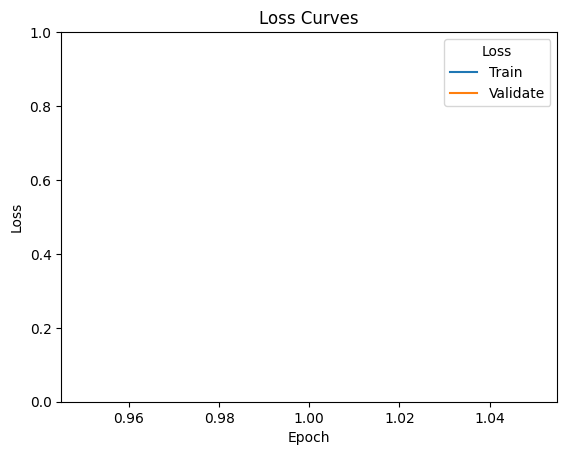

In [44]:
#Plot the training and validation losses

#Convert loss results into a datafram
result_preproc = pd.DataFrame({
    'Epoch': [i+1 for i in range(len(results["loss"]))], 
    'Train': results["loss"],
    'Validate': results["val_loss"]
    })

# Convert dataframe from wide to long format
df = pd.melt(result_preproc, ['Epoch'])

#Make plot
g = sns.lineplot(data=df, x='Epoch', y='value', hue='variable')
g.set_title("Loss Curves")
g.legend_.set_title("Loss")
g.set_ylabel('Loss')
g.set_ylim(0, 1)

**BATCHES**

In [45]:
"""
# Iterate through all batches in the dataset and print their shapes
for i, batch in enumerate(train_dataset):
    (img_batch, meta_batch), target_batch = batch
    
    # Print the shapes of the current batch
    print(f"Batch {i+1}:")
    print("  Image Batch Shape:", img_batch.shape)
    print("  Metadata Batch Shape:", meta_batch.shape)
    print("  Target Batch Shape:", target_batch.shape)
"""

'\n# Iterate through all batches in the dataset and print their shapes\nfor i, batch in enumerate(train_dataset):\n    (img_batch, meta_batch), target_batch = batch\n    \n    # Print the shapes of the current batch\n    print(f"Batch {i+1}:")\n    print("  Image Batch Shape:", img_batch.shape)\n    print("  Metadata Batch Shape:", meta_batch.shape)\n    print("  Target Batch Shape:", target_batch.shape)\n'

## 9) Predict Test Data

**TEST BATCHES**

In [46]:
"""
for i, batch in enumerate(test_dataset):
    (img_batch, meta_batch), target_batch = batch
    
    # Print the shapes of the current batch
    print(f"Batch {i+1}:")
    print("  Image Batch Shape:", img_batch.shape)
    print("  Metadata Batch Shape:", meta_batch.shape)
    print("  Target Batch Shape:", target_batch.shape)
"""

'\nfor i, batch in enumerate(test_dataset):\n    (img_batch, meta_batch), target_batch = batch\n    \n    # Print the shapes of the current batch\n    print(f"Batch {i+1}:")\n    print("  Image Batch Shape:", img_batch.shape)\n    print("  Metadata Batch Shape:", meta_batch.shape)\n    print("  Target Batch Shape:", target_batch.shape)\n'

**PREDICTIONS**

In [47]:
#Retrieve test predictions and real test values
predictions = model.predict(test_dataset, steps = nb_test_batches)
y_pred = np.array([round(i) for i  in predictions.flatten()])
y_test = np.concatenate([y for x, y in test_dataset], axis=0).flatten()
print("Shape of prediction data:", predictions.shape)

3952/3952 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step


ValueError: need at least one array to concatenate

In [ ]:
#test_dataset = make_dataset(hdf5_file, test_meta_dict, test_pos_isic_id, test_pos_target, batch_size = 1)
test_dataset.take(1)

In [59]:
#Calculate the loss
loss = sum(abs(y_test - y_pred))/len(y_pred)

In [60]:
#Determine true/false positives and negatives
pos_indices = y_test == 1
neg_indices = y_test == 0

#True positives
true_pos = sum(abs(y_test[pos_indices] == y_pred[pos_indices]))

#False negatives
false_neg = sum(abs(y_test[pos_indices] != y_pred[pos_indices]))

#True negatives
true_neg = sum(abs(y_test[neg_indices] == y_pred[neg_indices]))

#False positives
false_pos = sum(abs(y_test[neg_indices] != y_pred[neg_indices]))

In [ ]:
print("---TEST RESULTS---")
print("Loss on test data:", loss)
print("True positives:", true_pos)
print("False positives:", false_pos)
print("True negatives:", true_neg)
print("False negatives:", false_neg)